# GoogleNet（参数更少，复杂更低）

## GoogleNet介绍

对比NiN、VGG、AlexNet，与其去选择哪个卷积层和池化层最好，*不如我全都要*

### Inception块

- 4个路径从不同层面抽取信息，然后在**输出通道维**进行合并
  1. 第一个通道1\*1的卷积层（**抽取通道信息**）
  2. 第二个通道1\*1的卷积层（处理通道数） + 3\*3的卷积层，步幅1（**抽取空间信息**）
  3. 第三个通道1\*1的卷积层（处理通道数） + 5\*5的卷积层，步幅2（**抽取空间信息**）
  4. 第四个通道3\*3的最大池化层，步幅1（**抽取空间信息**） + 1\*1的卷积层（处理通道数）
- 以上四个通道均**不会改变图片大小，只是改变了通道数**，之后在进行输出通道维的合并。以下例子为stage3里面的第一段
  1. 输入192变为64
  2. 输入192先变为96再变成128
  3. 输入192先变成16再变成32（5\*5太贵，所以先变得很小）
  4. 输入192先不变（池化层）再变成32
  5. 总计64+128+32+32=256

优势：比3\*3，5\*5卷积层比，有**更少的参数和计算复杂度**

以上V1版本
-  V2版本使用batch normalization
-  V3版本
   -  5\*5换成多个3\*3
   -  5\*5换成1\*7和7\*1（分别对行和列做特征提取，**好处是可以减少计算量**）
   -  3\*3换成1\*3和3\*1
   -  更深
-  V4版本使用了残差连接及后面的ResNet

### GoogleNet构架

-  一个stage即对于图片长宽进行处理，继承了VGG里面卷积+池化的配置方法
-  全局池化即跟输入宽高一样大的池化层，它的意义时对于每个输出通道做平均，取平均数输出
-  **1*1卷积核可以重整通道数，如果通道数不改变也可以进行特征重整，或者降低计算量**

## 代码实现

In [38]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [39]:
class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 使用**kwargs的函数可以接受任意数量的命名参数，这些参数在函数内部被处理为一个字典。主要用于有多个可选参数，个数不定的情况。
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大池化层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

In [40]:
stage_1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), 
                   nn.ReLU(), 
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
stage_2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1), 
                   nn.ReLU(), 
                   nn.Conv2d(64, 192, kernel_size=3, stride=2, padding=1), 
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
stage_3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
stage_4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
stage_5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),# torch.nn.AdaptiveAvgPool2d(output_size)自适应平均池化层也有自适应最大池化层，直接告诉他你需要的输出高宽即可，他会帮你完成池化操作
                   nn.Flatten())

net = nn.Sequential(stage_1, stage_2, stage_3, stage_4, stage_5, 
                    nn.Linear(1024, 512), 
                    nn.ReLU(), nn.Dropout(0.3),
                    nn.Linear(512, 256),
                    nn.ReLU(), nn.Dropout(0.3),
                    nn.Linear(256, 128),
                    nn.ReLU(), nn.Dropout(0.3),
                    nn.Linear(128, 10)).cuda()

In [41]:
X = torch.rand(size=(1, 1, 224, 224),device='cuda:0')
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 192, 14, 14])
Sequential output shape:	 torch.Size([1, 480, 7, 7])
Sequential output shape:	 torch.Size([1, 832, 4, 4])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 512])
ReLU output shape:	 torch.Size([1, 512])
Dropout output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 256])
ReLU output shape:	 torch.Size([1, 256])
Dropout output shape:	 torch.Size([1, 256])
Linear output shape:	 torch.Size([1, 128])
ReLU output shape:	 torch.Size([1, 128])
Dropout output shape:	 torch.Size([1, 128])
Linear output shape:	 torch.Size([1, 10])


In [42]:
batch_size =128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224);

In [43]:
def train(net, train_iter, test_iter, num_epochs, lr): #此函数d2l.torch库中本身就有，但我们需要熟悉函数逻辑，这是后面深度学习中最常见的代码
    """用GPU训练模型(此处不需要，因为上面已经将net与X转到GPU中了)，模型使用Adam，损失函数是交叉熵"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])# 动图生成函数，包括训练损失，训练平均精确度，测试平均精确度
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)# 训练损失之和，训练准确率之和，样本数
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.cuda(), y.cuda() #训练集的数据移动到device上
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))# 此处是为了显示图像更方便，拆分等分显示图片
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec')

loss 0.187, train acc 0.934, test acc 0.920
2480.0 examples/sec


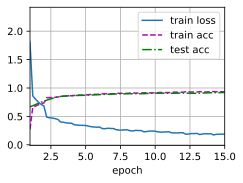

In [45]:
lr, num_epochs= 0.001, 15
train(net, train_iter, test_iter, num_epochs, lr)

调参记录：
-  在原有的GoogLeNet V1 全连接层增加了三层，但结果训练准确率0.934，测试集准确率0.915，有点过拟合，解决尝试使用**Dropout**
   -  Dropout如果过高会出现无法拟合的情况，故不可以设置过高，建议0.3、0.5
   -  Dropout会降低拟合速度，必要时候需要增加学习率和epoch
   -  最终确定三层Dropout均为0.3，增加epoch为15，结果为训练准确率0.934，测试集准确率0.920，相差不大，说明过拟合程度不高，结果较好。